In [1]:
import torch
import numpy as np
import pandas as pd
from copy import deepcopy
import re
from torch.nn.utils.rnn import pack_padded_sequence
import matplotlib.pyplot as plt

# 1 Loading data
Getting data from files, and converting the time values to seconds instead of 0:00:00.00

In [2]:
def grabDataThigh(filename : str):
    df = pd.read_csv(filename,header=1)
    dfThigh = df.loc[df["type"]=="t"]
    return dfThigh

def fixTimeData(df : pd.DataFrame):
    data = deepcopy(df)
    datadict = data.to_dict("list")
    timeValues = []
    x = datadict["time"]
    for i in range(len(x)):
        xValues = re.findall(r'[0-9.]+',x[i])
        tmpTime = 360*float(xValues[0])
        tmpTime = tmpTime + 60*float(xValues[1])
        tmpTime = tmpTime + float(xValues[2])
        timeValues.append(tmpTime)
    datadict["time"] = timeValues
    
    return datadict

In [ ]:
filename = r"C:\Users\jonas\Documents\GitHub\P8\Code\Data\Jonas walk 6 min 2.txt"
df = grabDataThigh(filename)
data = fixTimeData(df)
len(data)
data.pop('type', None)
inpuSize = len(data)

# 2 Transforming data to sequence tensor
This is done so the data is able to be provided to an LSTM

In [ ]:
def prepareSingleSequenceInput(dataDict):
    """
    Converts a feature-wise dictionary into an LSTM-compatible tensor.

    Parameters:
        dataDict (dict): Dictionary where each of the 26 keys maps to a list of values representing the sequence.

    Returns:
        torch.Tensor: Tensor of shape (seqLen, 1, inputSize=26)
    """
    featureNames = sorted(dataDict.keys())  # sort keys to maintain order
    seqLen = len(next(iter(dataDict.values())))
    inputSize = len(featureNames)

    # Stack features into shape: (seqLen, inputSize)
    sequence = [[dataDict[feat][t] for feat in featureNames] for t in range(seqLen)]

    # Convert to tensor and add batch dimension: (seqLen, 1, inputSize)
    tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(1)
    return tensor

tensor = prepareSingleSequenceInput(data)
print(tensor.shape)

torch.Size([24657, 1, 25])


In [5]:
def prepare_packed_input(dict_list, device=None):
    """
    Prepares a batch of variable-length sequences from a list of 26-feature dictionaries,
    and returns a PackedSequence for LSTM input.

    Parameters:
        dict_list (list): List of dictionaries (one per sequence), each with 26 keys and list of values.
        device (torch.device, optional): Device to place the tensor on (CPU or CUDA).

    Returns:
        PackedSequence: Packed LSTM input.
        list[int]: List of original sequence lengths.
    """
    feature_names = sorted(dict_list[0].keys())
    input_size = len(feature_names)
    batch_size = len(dict_list)

    # Get sequence lengths and sort by descending order (required for pack_padded_sequence)
    seq_lens = [len(next(iter(d.values()))) for d in dict_list]
    sorted_indices = sorted(range(len(seq_lens)), key=lambda i: -seq_lens[i])
    seq_lens_sorted = [seq_lens[i] for i in sorted_indices]
    sorted_dicts = [dict_list[i] for i in sorted_indices]

    max_seq_len = max(seq_lens_sorted)

    padded_sequences = []
    for d in sorted_dicts:
        seq_len = len(next(iter(d.values())))
        # Build sequence: shape (seq_len, input_size)
        seq = [[d[feat][t] for feat in feature_names] for t in range(seq_len)]
        # Pad to max_seq_len
        seq += [[0.0] * input_size] * (max_seq_len - seq_len)
        padded_sequences.append(seq)

    # (batch_size, seq_len, input_size)
    tensor = torch.tensor(padded_sequences, dtype=torch.float32)

    if device:
        tensor = tensor.to(device)

    # Transpose to (seq_len, batch_size, input_size)
    tensor = tensor.permute(1, 0, 2)

    # Pack the sequence
    packed_input = pack_padded_sequence(tensor, lengths=seq_lens_sorted, enforce_sorted=True)

    return packed_input, seq_lens_sorted



# 3 Creating an LSTM model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

torch.manual_seed(1)

In [7]:

class SequenceDataset(Dataset):
    def __init__(self, full_sequence, seq_len=100):
        """
        full_sequence: tensor of shape (total_len, input_size)
        """
        self.seq_len = seq_len
        self.data = full_sequence
        self.samples = self.create_sequences()

    def create_sequences(self):
        sequences = []
        for i in range(len(self.data) - self.seq_len):
            seq = self.data[i:i+self.seq_len]
            label = self.data[i+self.seq_len]  # e.g. next step prediction
            sequences.append((seq, label))
        return sequences

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [8]:
target_mean = tensor.mean(dim=0)
target_std = tensor.std(dim=0)
normalized_sequence = (tensor - target_mean) / target_std

dataset = SequenceDataset(normalized_sequence,250)

total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

trainDataset = dataset[:train_size]
valDataset = dataset[train_size:train_size + val_size]
testDataset = dataset[train_size + val_size:]


trainDataloader = DataLoader(trainDataset, batch_size=32, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=32)
testDataloader = DataLoader(testDataset, batch_size=32)

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=25, hidden_size=50, num_layers=1, output_size=25):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size)
        
        # Only use the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

# 4 Training the model

In [10]:
model = LSTMModel(input_size=25, hidden_size=50, output_size=25)  # Match output_size to target
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for batch_x, batch_y in dataloader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
'''

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\nfor batch_x, batch_y in dataloader:\n    batch_x, batch_y = batch_x.to(device), batch_y.to(device)\n'

Epoch 1/20 | Train Loss: 0.1764, MAE: 0.2500, R²: 0.7952 | Val Loss: 0.3084, MAE: 0.7130, R²: 0.9229
Epoch 2/20 | Train Loss: 0.0539, MAE: 0.1357, R²: 0.9374 | Val Loss: 0.2121, MAE: 0.5693, R²: 0.9470
Epoch 3/20 | Train Loss: 0.0416, MAE: 0.1154, R²: 0.9518 | Val Loss: 0.1771, MAE: 0.5038, R²: 0.9557
Epoch 4/20 | Train Loss: 0.0365, MAE: 0.1048, R²: 0.9577 | Val Loss: 0.1582, MAE: 0.4676, R²: 0.9605
Epoch 5/20 | Train Loss: 0.0334, MAE: 0.0978, R²: 0.9613 | Val Loss: 0.1492, MAE: 0.4418, R²: 0.9627
Epoch 6/20 | Train Loss: 0.0316, MAE: 0.0934, R²: 0.9633 | Val Loss: 0.1402, MAE: 0.4201, R²: 0.9650
Epoch 7/20 | Train Loss: 0.0303, MAE: 0.0906, R²: 0.9648 | Val Loss: 0.1394, MAE: 0.4205, R²: 0.9652
Epoch 8/20 | Train Loss: 0.0294, MAE: 0.0884, R²: 0.9659 | Val Loss: 0.1304, MAE: 0.4007, R²: 0.9674
Epoch 9/20 | Train Loss: 0.0286, MAE: 0.0865, R²: 0.9668 | Val Loss: 0.1287, MAE: 0.4019, R²: 0.9678
Epoch 10/20 | Train Loss: 0.0282, MAE: 0.0858, R²: 0.9672 | Val Loss: 0.1255, MAE: 0.3943, 

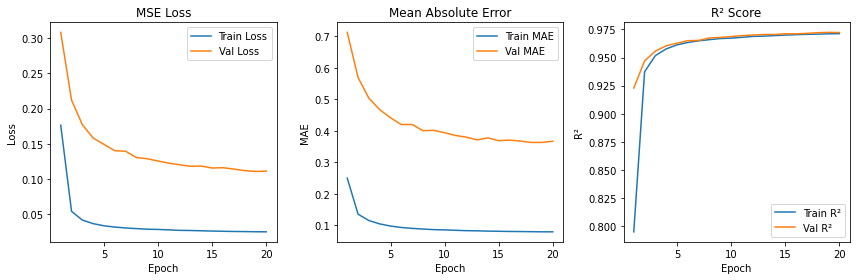

In [11]:
num_epochs = 20
train_losses, val_losses = [], []
train_maes, val_maes = [], []
train_r2s, val_r2s = [], []
epochList = list(i for i in range(num_epochs))

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total_train = 0
    train_mae_total = 0
    y_train_true = []
    y_train_pred = []

    for batch_x, batch_y in trainDataloader:
        # Move to GPU if available
        batch_x = batch_x.float()
        batch_x = batch_x.squeeze(2)
        batch_y = batch_y.float()
        batch_y = batch_y.squeeze(1)
        #print("Any NaNs?", torch.isnan(batch_x).any())
        #print("Min/Max:", batch_x.min(), batch_x.max())
        batch_x = torch.nan_to_num(batch_x, nan=0.0)
        batch_y = torch.nan_to_num(batch_y, nan=0.0)

        #print("Any NaNs y?", torch.isnan(batch_y).any())

        # Forward pass
        outputs = model(batch_x)
        #print("Any NaNs in output?", torch.isnan(outputs).any())
        # Compute loss
        loss = loss_fn(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        if torch.isnan(loss) or torch.isinf(loss):
            print("Loss is NaN or Inf!")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_mae_total += F.l1_loss(outputs, batch_y).item()

        y_train_true.append(batch_y.detach().cpu())
        y_train_pred.append(outputs.detach().cpu())
        

    avg_train_loss = train_loss / len(trainDataloader)
    avg_train_mae = train_mae_total / len(trainDataloader)

    
    y_train_true = torch.cat(y_train_true).numpy().flatten()
    y_train_pred = torch.cat(y_train_pred).numpy().flatten()
    train_r2 = r2_score(y_train_true, y_train_pred)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    val_mae_total = 0
    y_val_true = []
    y_val_pred = []

    with torch.no_grad():
        for batch_x, batch_y in trainDataloader:
            # Move to GPU if available
            batch_x = batch_x.float()
            batch_x = batch_x.squeeze(2)
            batch_y = batch_y.float()
            batch_y = batch_y.squeeze(1)
            #print("Any NaNs?", torch.isnan(batch_x).any())
            #print("Min/Max:", batch_x.min(), batch_x.max())
            batch_x = torch.nan_to_num(batch_x, nan=0.0)
            batch_y = torch.nan_to_num(batch_y, nan=0.0)

            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            val_loss += loss.item()
            val_mae_total += F.l1_loss(outputs, batch_y).item()

            y_val_true.append(batch_y.cpu())
            y_val_pred.append(outputs.cpu())


    avg_val_loss = val_loss / len(valDataloader)
    avg_val_mae = val_mae_total / len(valDataloader)

    
    y_val_true = torch.cat(y_val_true).numpy().flatten()
    y_val_pred = torch.cat(y_val_pred).numpy().flatten()
    val_r2 = r2_score(y_val_true, y_val_pred)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_maes.append(avg_train_mae)
    val_maes.append(avg_val_mae)
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)
    
    # 📊 Print the metrics
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, MAE: {avg_train_mae:.4f}, R²: {train_r2:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, MAE: {avg_val_mae:.4f}, R²: {val_r2:.4f}")
'''
fig, ax = plt.subplot(1,2)
ax[0].plot(epochList,trainLossList,label="Train Loss")
ax[0].plot(epochList,valLossList,label="Val Loss")
plt.legend()
plt.show()
'''

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, train_maes, label='Train MAE')
plt.plot(epochs, val_maes, label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot R² Score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_r2s, label='Train R²')
plt.plot(epochs, val_r2s, label='Val R²')
plt.title('R² Score')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()


# 5 Testing the model

In [14]:
def test(model, test_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_mae_total = 0
    y_test_true = []
    y_test_pred = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in test_loader:
            batchX, batchY = batch
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            batchX = batchX.float()
            batchX = batchX.squeeze(2)
            batchY = batchY.float()
            batchY = batchY.squeeze(1)
            batchX = torch.nan_to_num(batchX, nan=0.0)
            batchY = torch.nan_to_num(batchY, nan=0.0)

            # Forward pass
            outputs = model(batchX)
            
            # Compute loss
            loss = loss_fn(outputs, batchY)
            test_loss += loss.item()
            
            # Compute MAE
            test_mae_total += F.l1_loss(outputs, batchY).item()

            # Collect true and predicted values for R²
            y_test_true.append(batchY.cpu())
            y_test_pred.append(outputs.cpu())

    # Calculate average test loss and MAE
    avg_test_loss = test_loss / len(test_loader)
    avg_test_mae = test_mae_total / len(test_loader)

    # Flatten the predictions and batchY to calculate R²
    y_test_true = torch.cat(y_test_true).numpy().flatten()
    y_test_pred = torch.cat(y_test_pred).numpy().flatten()
    test_r2 = r2_score(y_test_true, y_test_pred)

    print(f"Test Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.4f}, Test R²: {test_r2:.4f}")

    return avg_test_loss, avg_test_mae, test_r2

avg_test_loss, avg_test_mae, test_r2 = test(model,testDataloader,loss_fn,"cpu")

Test Loss: 0.0653, Test MAE: 0.1505, Test R²: 0.9329


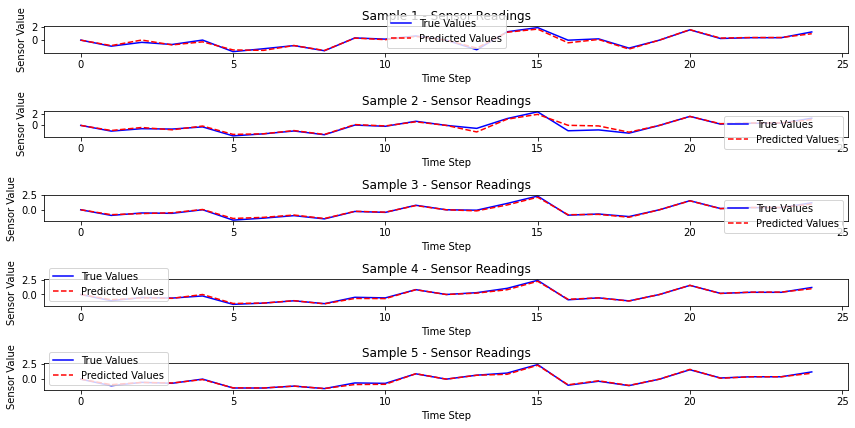

In [16]:

def collect_outputs_and_batchY(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in data_loader:
            batchX, batchY = batch
            batchX, batchY = batchX.to(device), batchY.to(device)

            
            batchX = batchX.float()
            batchX = batchX.squeeze(2)
            batchY = batchY.float()
            batchY = batchY.squeeze(1)
            batchX = torch.nan_to_num(batchX, nan=0.0)
            batchY = torch.nan_to_num(batchY, nan=0.0)

            outputs = model(batchX)

            # Collect the true and predicted values
            y_true.append(batchY.cpu().numpy())  # Move to CPU and convert to numpy
            y_pred.append(outputs.cpu().numpy())  # Same for predictions

    # Flatten the list of batches to get all values
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    
    return y_true, y_pred

def plot_predictions_vs_actuals(y_true, y_pred, num_samples=5):
    """
    Plots the predicted vs actual sensor values for a few samples.
    
    :param y_true: Actual sensor readings (ground truth)
    :param y_pred: Predicted sensor readings
    :param num_samples: Number of samples to plot (default is 5)
    """
    plt.figure(figsize=(12, 6))

    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)  # Create a subplot for each sample
        plt.plot(y_true[i], label="True Values", color='blue')
        plt.plot(y_pred[i], label="Predicted Values", color='red', linestyle='--')
        plt.title(f"Sample {i+1} - Sensor Readings")
        plt.xlabel("Time Step")
        plt.ylabel("Sensor Value")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
y_true, y_pred = collect_outputs_and_batchY(model, testDataloader, "cpu")
plot_predictions_vs_actuals(y_true, y_pred)